In [1]:
# PyDESeq2 Workflow: Differential Expression
# Soybean at 14_dpi (day 14: post innoculation)

In [2]:
## Import Necessary Libraries

In [3]:
import os
import pandas as pd
import numpy as np
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from adjustText import adjust_text

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

In [4]:
import warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
## Load Data

In [6]:
df = pd.read_csv('combined_reads_soybean_dpi14.csv')
df.head()

,Geneid,Alternaria_T14_1,Alternaria_T14_2,Alternaria_T14_3,Alternaria_T14_4,Control_T14_1,Control_T14_2,Control_T14_3,Control_T14_4
0,GLYMA_18G079000,104,50,50,22,48,22,77,29
1,GLYMA_18G080300,1954,1834,1854,1150,1507,1391,1671,1496
2,GLYMA_18G224800,16,14,13,4,5,1,5,3
3,GLYMA_18G197600,5272,4665,4110,2445,3638,3939,4330,4389
4,GLYMA_18G079400,2725,2664,2371,2270,2534,1999,2551,2430


In [7]:
# set Geneid as index
data = df.set_index('Geneid')
data.head(2)

,Alternaria_T14_1,Alternaria_T14_2,Alternaria_T14_3,Alternaria_T14_4,Control_T14_1,Control_T14_2,Control_T14_3,Control_T14_4
Geneid,,,,,,,,
GLYMA_18G079000,104,50,50,22,48,22,77,29
GLYMA_18G080300,1954,1834,1854,1150,1507,1391,1671,1496


In [8]:
# filter out genes and keep rows where the sum is greater than 10; then transpose
data = data[data.sum(axis = 1) > 10].T 
data

Geneid,GLYMA_18G079000,GLYMA_18G080300,GLYMA_18G224800,GLYMA_18G197600,GLYMA_18G079400,GLYMA_18G003000,GLYMA_18G291100,GLYMA_18G058900,GLYMA_18G145000,GLYMA_18G231300,...,GLYMA_U005500,GLYMA_U005400,GLYMA_U005800,GLYMA_U007300,GLYMA_U007200,GLYMA_U009100,GLYMA_U009000,GLYMA_U007000,GLYMA_U008200,GLYMA_U022500
Alternaria_T14_1,104,1954,16,5272,2725,923,1139,9366,324,1069,...,165,36,121,39,130,131,52,4382,10,723
Alternaria_T14_2,50,1834,14,4665,2664,1007,1065,9249,230,761,...,32,37,14,4,14,37,10,3706,100,592
Alternaria_T14_3,50,1854,13,4110,2371,797,1120,8169,251,808,...,73,67,51,19,17,72,6,3631,25,524
Alternaria_T14_4,22,1150,4,2445,2270,976,787,9854,146,597,...,37,17,32,2,29,56,13,2428,287,284
Control_T14_1,48,1507,5,3638,2534,627,1040,6868,114,2006,...,51,42,105,17,109,209,37,5890,2,896
Control_T14_2,22,1391,1,3939,1999,555,818,5528,158,1698,...,70,20,66,13,41,128,21,5623,8,429
Control_T14_3,77,1671,5,4330,2551,753,1040,6881,145,2417,...,58,26,64,16,56,128,48,6530,8,571
Control_T14_4,29,1496,3,4389,2430,954,694,6256,111,2504,...,29,26,58,14,63,137,28,7266,0,518


In [9]:
# Create Metadata

In [10]:
samples = data.index.tolist()

In [11]:
metadata = pd.DataFrame({
    'Sample': samples,
    'condition': ['Treatment'] * 4 + ['Control'] * 4,
    'group': ['X', 'Y', 'X', 'Y', 'X', 'Y', 'X', 'Y']
})

metadata.set_index('Sample', inplace=True)

In [12]:
metadata

,condition,group
Sample,,
Alternaria_T14_1,Treatment,X
Alternaria_T14_2,Treatment,Y
Alternaria_T14_3,Treatment,X
Alternaria_T14_4,Treatment,Y
Control_T14_1,Control,X
Control_T14_2,Control,Y
Control_T14_3,Control,X
Control_T14_4,Control,Y


In [13]:
# Single Factor Analysis

In [14]:
# Initialize the DESeq2 dataset using the DeseqDataSet class
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=data,
    metadata=metadata,
    design_factors="condition",
    refit_cooks=True,
    inference=inference,
)

In [15]:
dds

AnnData object with n_obs × n_vars = 8 × 43102
    obs: 'condition', 'group'
    obsm: 'design_matrix'

In [16]:
dds.obs

,condition,group
Sample,,
Alternaria_T14_1,Treatment,X
Alternaria_T14_2,Treatment,Y
Alternaria_T14_3,Treatment,X
Alternaria_T14_4,Treatment,Y
Control_T14_1,Control,X
Control_T14_2,Control,Y
Control_T14_3,Control,X
Control_T14_4,Control,Y


In [17]:
dds.var

""
Geneid
GLYMA_18G079000
GLYMA_18G080300
GLYMA_18G224800
GLYMA_18G197600
GLYMA_18G079400
...
GLYMA_U009100
GLYMA_U009000
GLYMA_U007000


In [18]:
dds.X

array([[ 104, 1954,   16, ..., 4382,   10,  723],
       [  50, 1834,   14, ..., 3706,  100,  592],
       [  50, 1854,   13, ..., 3631,   25,  524],
       ...,
       [  22, 1391,    1, ..., 5623,    8,  429],
       [  77, 1671,    5, ..., 6530,    8,  571],
       [  29, 1496,    3, ..., 7266,    0,  518]])

In [19]:
dds.X.shape

(8, 43102)

In [20]:
# run deseq2 analysis
dds.deseq2()

Fitting size factors...
... done in 0.05 seconds.

Fitting dispersions...
... done in 97.54 seconds.

Fitting dispersion trend curve...
... done in 4.49 seconds.

Fitting MAP dispersions...
... done in 125.28 seconds.

Fitting LFCs...
... done in 60.46 seconds.

Refitting 0 outliers.



In [21]:
dds

AnnData object with n_obs × n_vars = 8 × 43102
    obs: 'condition', 'group'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks'

In [22]:
# Dispersions and LFCs (in natural log scale)
dds.varm["dispersions"]

array([0.20543339, 0.01079432, 0.4857749 , ..., 0.01935004, 1.65608844,
       0.05094408])

In [23]:
dds.varm["LFC"]

,intercept,condition_Treatment_vs_Control
Geneid,,
GLYMA_18G079000,3.792497,0.140472
GLYMA_18G080300,7.364810,0.012438
GLYMA_18G224800,1.270982,1.102990
GLYMA_18G197600,8.359257,-0.106734
GLYMA_18G079400,7.813563,-0.025346
...,...,...
GLYMA_U009100,5.051056,-0.813782
GLYMA_U009000,3.532963,-0.621834
GLYMA_U007000,8.799281,-0.690150


In [24]:
# Principal Component Analysis (PCA)

In [25]:
# Log-transform the counts
log_transformed = np.log2(data + 1)

In [26]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(log_transformed)

In [27]:
# Create a DataFrame with PCA results and metadata
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['condition'] = metadata['condition'].values

In [28]:
# Calculate explained variance for the plot
explained_variance = pca.explained_variance_ratio_

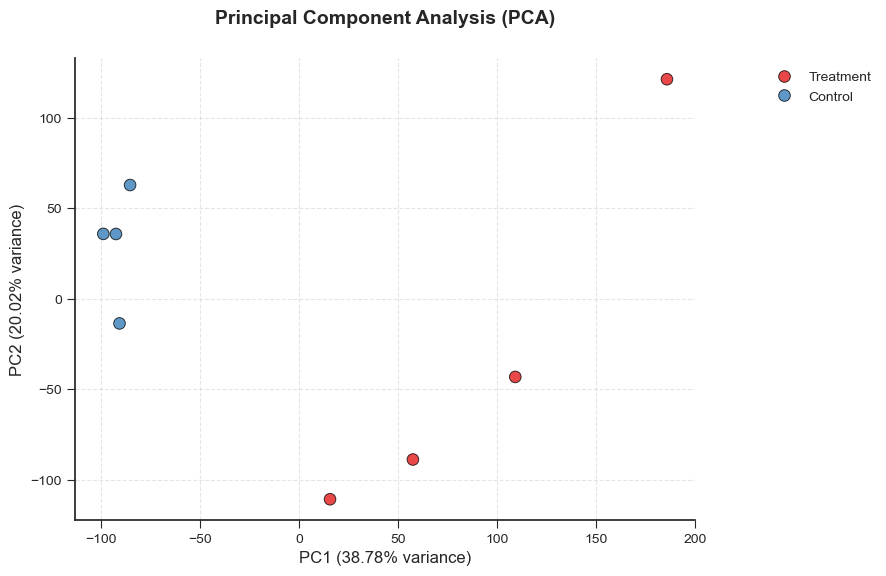

In [29]:
# Set a clean and professional style
plt.style.use('seaborn-ticks')

# Create PCA plot
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(
    x='PC1', y='PC2', hue='condition', data=pca_df, 
    s=70, edgecolor='black', alpha=0.8, palette='Set1'
)

# Label axes with explained variance
plt.xlabel(f'PC1 ({explained_variance[0] * 100:.2f}% variance)', fontsize=12)
plt.ylabel(f'PC2 ({explained_variance[1] * 100:.2f}% variance)', fontsize=12)

# Title and legend improvements
plt.title('Principal Component Analysis (PCA)', fontsize=14, weight='bold', pad=25)
plt.legend(title='', bbox_to_anchor=(1.1, 1), loc='upper left', fontsize=10)

# Improve visual clarity
plt.grid(True, linestyle='--', alpha=0.5)
sns.despine()  # Removes unnecessary borders

# Save figure in high resolution
plt.savefig('PCA_soybean_14dpi.png', dpi=600, bbox_inches='tight')
plt.show()

In [30]:
# Statistical Analysis with the DeseqStats class

In [31]:
stat_res = DeseqStats(dds, inference=inference)

In [32]:
# Wald Test
stat_res.summary()

Running Wald tests...
... done in 17.83 seconds.



Log2 fold change & Wald test p-value: condition Treatment vs Control
                    baseMean  log2FoldChange     lfcSE      stat  \
Geneid                                                             
GLYMA_18G079000    47.515080        0.202658  0.485747  0.417209   
GLYMA_18G080300  1589.107541        0.017945  0.109061  0.164538   
GLYMA_18G224800     7.087969        1.591278  0.839536  1.895425   
GLYMA_18G197600  4053.190413       -0.153985  0.159882 -0.963112   
GLYMA_18G079400  2443.550042       -0.036566  0.131756 -0.277532   
...                      ...             ...       ...       ...   
GLYMA_U009100     112.657850       -1.174039  0.362986 -3.234395   
GLYMA_U009000      26.228695       -0.897117  0.657484 -1.364469   
GLYMA_U007000    4977.098284       -0.995677  0.142729 -6.975978   
GLYMA_U008200      62.579947        4.693529  1.358171  3.455773   
GLYMA_U022500     555.470479       -0.339938  0.234359 -1.450498   

                       pvalue          padj  


In [33]:
# Expressed genes
res = stat_res.results_df
res.head(5)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Geneid,,,,,,
GLYMA_18G079000,47.515080,0.202658,0.485747,0.417209,0.676526,0.831693
GLYMA_18G080300,1589.107541,0.017945,0.109061,0.164538,0.869308,0.939432
GLYMA_18G224800,7.087969,1.591278,0.839536,1.895425,0.058036,0.174975
GLYMA_18G197600,4053.190413,-0.153985,0.159882,-0.963112,0.335491,0.564048
GLYMA_18G079400,2443.550042,-0.036566,0.131756,-0.277532,0.781371,0.893099


In [34]:
# Filter 'res' to identify significantly expressed genes
sigs = res[(res.padj < 0.01) & (abs(res.log2FoldChange) > 1.5)]
sigs

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Geneid,,,,,,
GLYMA_18G231300,1505.896302,-1.560721,0.165133,-9.451275,3.347283e-21,1.008111e-18
GLYMA_18G184600,1103.765881,-2.092190,0.343067,-6.098487,1.070770e-09,4.702932e-08
GLYMA_18G089100,14.878991,6.539420,1.965994,3.326266,8.801797e-04,6.732684e-03
GLYMA_18G200100,131.351419,1.814435,0.550744,3.294516,9.859123e-04,7.401635e-03
GLYMA_18G047800,59.554930,3.091374,0.483864,6.388925,1.670554e-10,8.922097e-09
...,...,...,...,...,...,...
GLYMA_U038200,128.610717,3.186902,0.321371,9.916574,3.526531e-23,1.239112e-20
GLYMA_U037600,112.070854,-1.967069,0.514696,-3.821808,1.324768e-04,1.381539e-03
GLYMA_U039300,28.598982,1.725214,0.481105,3.585940,3.358664e-04,3.014444e-03


In [35]:
dds

AnnData object with n_obs × n_vars = 8 × 43102
    obs: 'condition', 'group'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks'

In [36]:
#calculate the natural logarithm of the normalized expression values
dds.layers['normed_counts']
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])
dds.layers['log1p']

array([[4.4480562 , 7.37015882, 2.63862498, ..., 8.1774365 , 2.21060332,
        6.37700589],
       [3.82805361, 7.4088993 , 2.60951313, ..., 8.11204698, 4.51026526,
        6.27942151],
       [3.85342233, 7.44564909, 2.56495573, ..., 8.11752587, 3.18126045,
        6.18352116],
       ...,
       [3.26524215, 7.3736697 , 0.76306435, ..., 8.77003969, 2.31833142,
        6.1987547 ],
       [4.2937074 , 7.35796892, 1.73884133, ..., 8.72047914, 2.14067697,
        6.28540794],
       [3.52381142, 7.43772423, 1.48270364, ..., 9.01766775, 0.        ,
        6.37826004]])

In [37]:
dds_sigs = dds[:, sigs.index]
dds_sigs

View of AnnData object with n_obs × n_vars = 8 × 1574
    obs: 'condition', 'group'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'log1p'

In [38]:
# Heatmap

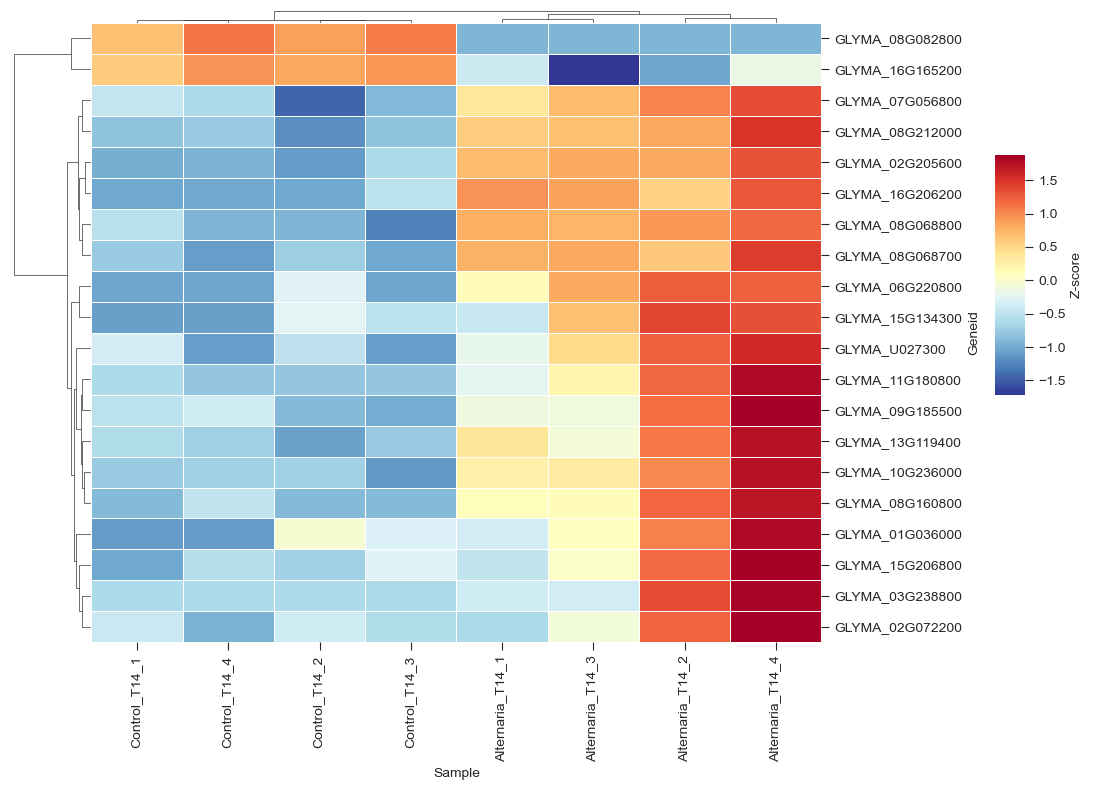

In [39]:
# Create a DataFrame from the log-transformed expression matrix
grapher = pd.DataFrame(dds_sigs.layers['log1p'].T,
                       index=dds_sigs.var_names, columns=dds_sigs.obs_names)

# Select the top 20 most variable genes based on standard deviation
top_genes = grapher.var(axis=1).nlargest(20).index
grapher_top = grapher.loc[top_genes]

# Create a hierarchical clustering heatmap with an aligned color bar
g = sns.clustermap(grapher_top, z_score=0, cmap='RdYlBu_r', figsize=(10, 8),
                   linewidths=0.5, xticklabels=True, yticklabels=True,
                   cbar_pos=(1, 0.5, 0.03, 0.3),  # Aligns color bar to the right
                   dendrogram_ratio=(0.1, 0.02),  # Adjusts dendrogram proportions
                   cbar_kws={'label': 'Z-score'})  # Labels the color bar

plt.savefig('Heatmap_soybean_14dpi.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

In [40]:
# Volcano plot

In [41]:
# Define significance thresholds
padj_threshold = 0.01
logFC_threshold = 1.5

In [42]:
# Filter significant results and split
significant_sigs = res[(res['padj'] < padj_threshold) & (abs(res['log2FoldChange']) > logFC_threshold)]
positive_sigs = significant_sigs[significant_sigs['log2FoldChange'] > 0]
negative_sigs = significant_sigs[significant_sigs['log2FoldChange'] < 0]

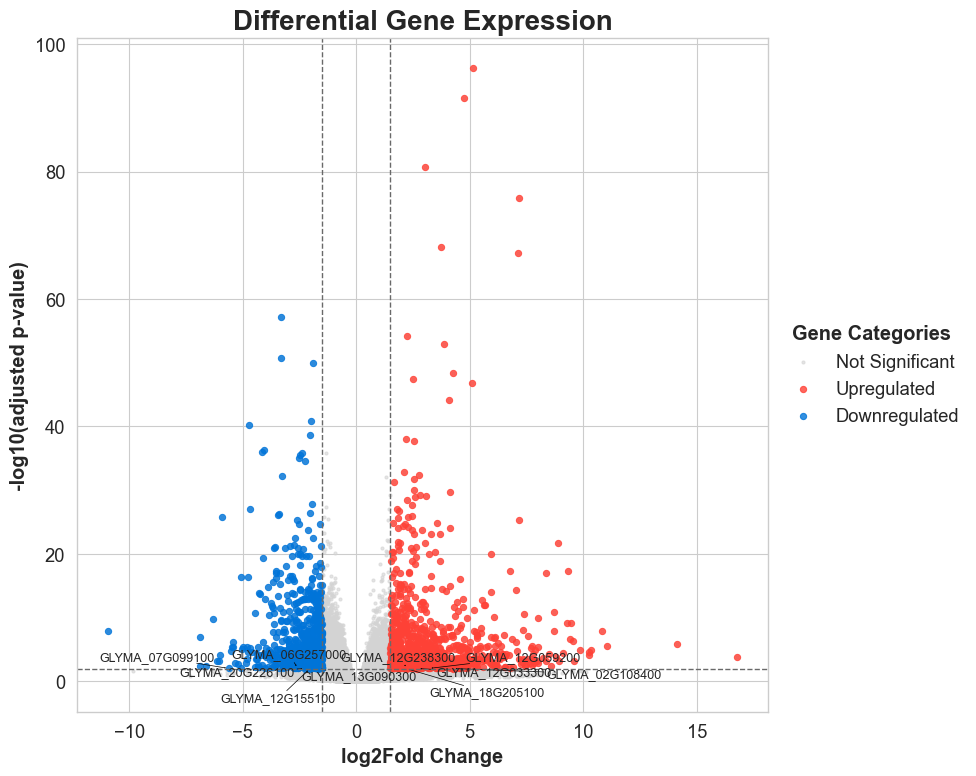

In [43]:
# Set up the plot style
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

# Create volcano plot
plt.scatter(res['log2FoldChange'], -np.log10(res['padj']), color='lightgray', alpha=0.6, s=5, label='Not Significant')
plt.scatter(positive_sigs['log2FoldChange'], -np.log10(positive_sigs['padj']), color='#FF4136', alpha=0.8, s=20, label='Upregulated')
plt.scatter(negative_sigs['log2FoldChange'], -np.log10(negative_sigs['padj']), color='#0074D9', alpha=0.8, s=20, label='Downregulated')

# Add threshold lines
plt.axhline(-np.log10(padj_threshold), color='dimgray', linestyle='--', linewidth=1)
plt.axvline(logFC_threshold, color='dimgray', linestyle='--', linewidth=1)
plt.axvline(-logFC_threshold, color='dimgray', linestyle='--', linewidth=1)

# Customize the plot
plt.xlabel('log2Fold Change', fontweight='bold')
plt.ylabel('-log10(adjusted p-value)', fontweight='bold')
plt.title('Differential Gene Expression', fontsize=20, fontweight='bold')

# Add legend
legend = plt.legend(title='Gene Categories', loc='center left', bbox_to_anchor=(1, 0.5))
plt.setp(legend.get_title(), fontweight='bold')

# Label top significant genes
top_genes = significant_sigs.nlargest(10, 'padj')
texts = []
for i, row in top_genes.iterrows():
    texts.append(plt.text(row['log2FoldChange'], -np.log10(row['padj']), i, fontsize=9))
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

# Adjust layout and save
plt.tight_layout()
plt.savefig('volcano_plot_soybean_14dpi.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# Download Data

In [44]:
res.to_csv('expreesed_genes_soybean_14dpi.csv')
sigs.to_csv('sigs_expreesed_genes_soybean_14dpi.csv')